In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.special import kv  # K_v BESSEL FUNCTIONS


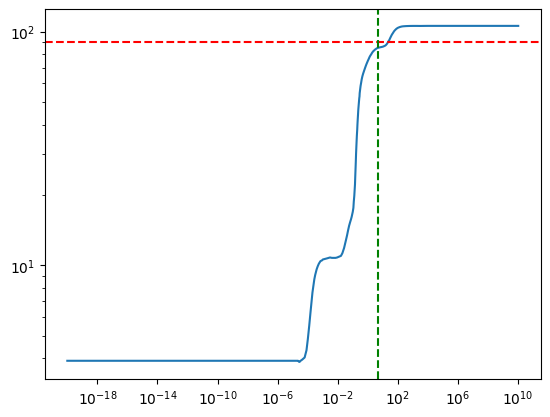

In [3]:
path = "/Users/charlottemyers/projects/ctp/heffBW.dat"
data = np.loadtxt(path)
T_data = data[:,0]
g_eff = data[:,1]

m = 100.0  # DM mass in GeV
#plot
plt.plot(T_data, g_eff)
plt.xscale('log')
plt.yscale('log')
plt.axhline(y=GSTAR, color='r', linestyle='--')
# expected x of freeze out
plt.axvline(x=m/20, color='g', linestyle='--')

# define a function to return gstar at a given T
def gstar_interp(T):
    #if T < T_data.min() or T > T_data.max():
        #return GSTAR
    return np.interp(T, T_data, g_eff)

In [ ]:
# # Solve coupled boltzmann system for two species

# sigmav_AA_xx = 1e-9  # cm^3/s
# sigmav_xx_ff = 1e-9  # cm^3/s
# sigmav_deltaE = 1e-9  # cm^3/s

# # define dark photon and DM masses
# mA = 12.0  # GeV
# mchi = 120 # GeV
# Mpl = 1.2209e19
# GCHI = 2




# def H_of_T(T, time_dep_gstar = False):
#     if time_dep_gstar:
#         gstar = gstar_interp(T)
#     else:
#         gstar = GSTAR
#     return np.sqrt(8.0*np.pi**3/90.0 * gstar * T**2 / Mpl)

# def s_of_T(T, time_dep_gstar = False):   # uses g_{*s}(T)
#     if time_dep_gstar:
#         gstars = gstar_interp(T)
#     else:
#         gstars = GSTAR
#     return (2.0*np.pi**2/45.0) * gstars(T) * T**3





# def dln_gstars_dlnT(T, delta=1e-5):
#     """Numerical derivative of ln(g*_s) w.r.t. ln(T)."""
#     gstar_plus = gstar_interp(T * (1.0 + delta))
#     gstar_minus = gstar_interp(T * (1.0 - delta))
#     return (np.log(gstar_plus) - np.log(gstar_minus)) / (2.0 * np.log(1.0 + delta))

# def C_of_T(T):   # 1 - (1/3) d ln g*_s / d ln T
#     return 1.0 - (1.0/3.0) * dln_gstars_dlnT(T)

# def n_eq_species(m, g, Tspec):
#     x = m / Tspec
#     return g * (m*m*Tspec)/(2.0*np.pi**2) * kv(2, x)

# def rhs_n(x, y):
#     nchi, nA0 = y
#     T  = mchi / x
#     Th = xi_of_T(T) * T

#     H  = H_total(T, Th)
#     neq_chi = n_eq_species(mchi, GCHI, Th)
#     neq_A0  = n_eq_species(mA0,  gA0,  Th)

#     sv_chi = sigmav_chichi_to_SM(Th)   # or constant; HS-averaged
#     sv_AA  = sigmav_AA_to_chichi(Th)   # HS-averaged

#     C  = corr_SM(T)

#     term_SM  = sv_chi * (nchi**2 - neq_chi**2)
#     term_AA  = sv_AA  * (nA0**2  - (neq_A0**2 / neq_chi**2) * nchi**2)

#     dnchi_dx = ( -3.0*nchi/x - (term_SM - term_AA)/(H*x) ) * C
#     dnA0_dx  = ( -3.0*nA0/x - (term_AA)/(H*x) ) * C

#     # if Gamma_A0 > 0.0:
#     #     nA0_eq_decay = n_eq_species(mA0, gA0, T)
#     #     dnA0_dx += -(Gamma_A0/(H*x)) * (nA0 - nA0_eq_decay) * C

#     return np.array([dnchi_dx, dnA0_dx])


In [ ]:
#!/usr/bin/env python3
"""
Coupled Boltzmann (n-space) with a separate hidden temperature Th (no 3->2)
---------------------------------------------------------------------------

State variables: y = [n_chi, n_Ap, Th]
x = m_chi / T   (SM temperature T sets x)

Equations in time t:
  dot{n_i} + 3 H n_i = C_i(n, T, Th)         for i = chi, A'
  d( rho_h )/dt + 3 H (rho_h + P_h) = Q_h     (hidden-sector energy)

We compute dot{Th} from the energy equation and then convert all derivatives
to d/dx using dx/dt = H x / [1 + (1/3) d ln g_*s^SM / d ln T].
"""

import numpy as np
from scipy.integrate import solve_ivp
from scipy.special import kv  # K_v
import matplotlib.pyplot as plt

# ----------------------------
# Model parameters (edit these)
# ----------------------------
Mpl   = 1.2209e19      # GeV (Planck mass used in H)
mchi  = 100.0          # GeV
gchi  = 2.0            # internal dof of chi
mAp   = 120.0          # GeV
gAp   = 3.0            # internal dof of A' (example)

# Thermally-averaged 2->2 cross sections (INPUT in cm^3/s)
sig_chichi_to_ff  = 2.0e-26   # <σv> for χχ ↔ f f̄  (portal to SM)
sig_AA_to_chichi  = 1.0e-26   # <σv> for A'A' ↔ χχ   (hidden-sector)
Gamma_Ap          = 0.0       # A' decay width [GeV]; set >0 to include decays

# --- Unit conversion: cm^3/s -> GeV^-2 ---
cm_to_GeV_inv = 5.0677307e13
s_to_GeV_inv  = 1.5192674e24
cm3s_to_GeV2  = (cm_to_GeV_inv**3) / s_to_GeV_inv
sig_chichi_to_ff *= cm3s_to_GeV2
sig_AA_to_chichi *= cm3s_to_GeV2

# ----------------------------
# SM g*(T), g*_s(T)  (replace with your splines/tables if available)
# ----------------------------
def gstar_SM(T):      # for H via rho_SM
    return 90.0

def gstars_SM(T):     # for entropy and the dx/dt factor
    return 90.0

def dln_gstars_SM_dlnT(T):
    # If you have a spline g*_s(T), return (T/g*_s) * d g*_s/dT
    return 0.0

# ----------------------------
# Optional: include hidden energy in H?
# ----------------------------
INCLUDE_HS_IN_H = True  # set False to use H ≈ H_SM(T) only

# ----------------------------
# Helper thermodynamics
# ----------------------------
def H_of_T(T, rho_h=0.0):
    """Hubble from SM (and optionally HS)."""
    rho_SM = (np.pi**2/30.0) * gstar_SM(T) * T**4
    if INCLUDE_HS_IN_H:
        rho_tot = rho_SM + rho_h
    else:
        rho_tot = rho_SM
    return np.sqrt((8.0*np.pi/3.0) * rho_tot) / Mpl

def s_SM(T):
    """SM entropy density."""
    return (2.0*np.pi**2/45.0) * gstars_SM(T) * T**3

def dx_dt(T):
    """dx/dt for x = mchi / T."""
    corr = 1.0 + (1.0/3.0) * dln_gstars_SM_dlnT(T)
    return H_of_T(T) * (mchi/T) / corr

def neq(m, g, Temp):
    """Equilibrium number density at temperature Temp (K2 form, works for all x)."""
    x = m / Temp
    return g * (m*m*Temp) / (2.0*np.pi**2) * kv(2, x)

# Hidden-sector (assumed nonrelativistic regime for ρ, P)
def rho_h(nchi, nAp, Th):
    # ρ_i ≈ m_i n_i + 3/2 n_i Th   ;   P_i ≈ n_i Th
    return mchi*nchi + mAp*nAp + 1.5*(nchi + nAp)*Th

def P_h(nchi, nAp, Th):
    return (nchi + nAp) * Th

# If you want an elastic energy-exchange term with the SM (kinetic coupling),
# define it here. Otherwise this returns 0 (no elastic heating/cooling).
def Q_elastic(T, Th, nchi):
    """
    Energy exchange via elastic χ–SM scattering:
      Q_el ≈ - <σ v δE>_{χ f -> χ f} nχ n_f  (absorbed n_f into an effective rate)
    Return [GeV^4], same units as energy density rate terms.
    """
    return 0.0

# For χχ ↔ f f̄ and A'A' ↔ χχ we allow T-dependent thermal averages if desired.
def sigmav_chichi_to_ff(Th):
    return sig_chichi_to_ff  # could be function of x_h = mchi/Th

def sigmav_AA_to_chichi(Th):
    return sig_AA_to_chichi  # could be function of mAp/Th, etc.

# ----------------------------
# Time-domain collision terms (match your example, with NO 3->2)
# ----------------------------
def collisions(nchi, nAp, T, Th):
    """
    Return (C_chi, C_Ap, Q_h) where:
      dot n_i + 3 H n_i = C_i
      d(ρ_h)/dt + 3 H (ρ_h + P_h) = Q_h
    """
    # Equilibria used in detailed-balance combinations:
    # - For χχ ↔ f f̄ (portal to SM), example uses n_{χ,0}(T) (SM temperature)
    nchi_eq_SM = neq(mchi, gchi, T)

    # - For A'A' ↔ χχ (hidden-sector), example uses T' = Th
    nAp_eq_Th  = neq(mAp,  gAp,  Th)
    nchi_eq_Th = neq(mchi, gchi, Th)

    sv_SM = sigmav_chichi_to_ff(Th)   # thermal average over HS χ distribution
    sv_AA = sigmav_AA_to_chichi(Th)

    # Number collision terms:
    C_chi = -0.5 * sv_SM * (nchi**2 - nchi_eq_SM**2) \
            +      sv_AA * (nAp**2  - (nAp_eq_Th**2 / nchi_eq_Th**2) * nchi**2)

    C_Ap  = -      sv_AA * (nAp**2  - (nAp_eq_Th**2 / nchi_eq_Th**2) * nchi**2) \
            -      Gamma_Ap * (nAp - neq(mAp, gAp, T))   # decay to SM bath (eq at T)

    # Energy exchange terms Q_h (hidden ↔ SM), as in your example (16):
    #  - elastic χ–f scattering:
    Q_el = Q_elastic(T, Th, nchi)
    #  - A' decays:
    Q_dec = - mAp * Gamma_Ap * (nAp - neq(mAp, gAp, T))
    #  - χχ ↔ f f̄ annihilations:
    Q_ann = - 0.5 * mchi * sv_SM * (nchi**2 - nchi_eq_SM**2)

    Q_h = Q_el + Q_dec + Q_ann
    return C_chi, C_Ap, Q_h

# ----------------------------
# Convert to x-domain RHS: d/dx = (1/(dx/dt)) d/dt
# ----------------------------
def rhs_x(x, y):
    """
    y = [nchi, nAp, Th]; x = mchi/T
    """
    nchi, nAp, Th = y
    T   = mchi / x

    # Compute H using current hidden energy (if enabled)
    H    = H_of_T(T, rho_h(nchi, nAp, Th) if INCLUDE_HS_IN_H else 0.0)
    xdot = dx_dt(T)  # = H x / [1 + (1/3) d ln g_*s / d ln T]

    # Collisions (time-domain)
    C_chi, C_Ap, Qh = collisions(nchi, nAp, T, Th)

    # Time derivatives of number densities:
    dnchi_dt = -3.0 * H * nchi + C_chi
    dnAp_dt  = -3.0 * H * nAp  + C_Ap

    # Hidden-sector energy/pressure and their time derivative relation for Th:
    nh   = nchi + nAp
    rhoh = rho_h(nchi, nAp, Th)
    Ph   = P_h(nchi, nAp, Th)

    # dot{rho_h} = sum_i m_i dot{n_i} + 3/2 (nh dot{Th} + Th dot{nh})
    dnh_dt = dnchi_dt + dnAp_dt

    # Energy equation: dot{rho_h} + 3H(rho_h+P_h) = Q_h
    # => (sum m_i dot n_i) + (3/2)(nh dot Th + Th dnh_dt) + 3H(rho_h+P_h) = Q_h
    # Solve for dot Th:
    sum_m_dni = mchi*dnchi_dt + mAp*dnAp_dt
    dotTh = (2.0/(3.0*max(nh, 1e-300))) * (Qh - sum_m_dni - 1.5*Th*dnh_dt - 3.0*H*(rhoh + Ph))

    # Convert to x-derivatives
    dnchi_dx = dnchi_dt / xdot
    dnAp_dx  = dnAp_dt  / xdot
    dTh_dx   = dotTh    / xdot

    return np.array([dnchi_dx, dnAp_dx, dTh_dx])

# ----------------------------
# Integrate
# ----------------------------
x_i, x_f = 1.0, 1.0e3
T_i = mchi / x_i
Th_i = T_i  # start with HS in kinetic eq. with SM (Th = T)
nchi_i = neq(mchi, gchi, T_i)
nAp_i  = neq(mAp,  gAp,  T_i)
y0 = np.array([nchi_i, nAp_i, Th_i])

xs  = np.geomspace(x_i, x_f, 2000)
sol = solve_ivp(rhs_x, (x_i, x_f), y0, t_eval=xs, method="Radau", rtol=1e-7, atol=1e-12)
if not sol.success:
    raise RuntimeError(sol.message)

nchi, nAp, Th = sol.y
T = mchi / xs

# Diagnostics: yields vs SM entropy (flat after freeze-out if everything is consistent)
def Y(n, T): return n / s_SM(T)
Ychi = Y(nchi, T)
YAp  = Y(nAp,  T)

fig, ax = plt.subplots(1, 2, figsize=(10.3, 4))
ax[0].loglog(xs, Ychi, label=r'$Y_\chi$')
ax[0].loglog(xs, YAp,  '--', label=r'$Y_{A^\prime}$')
ax[0].set_xlabel(r'$x=m_\chi/T$'); ax[0].set_ylabel(r'$Y=n/s_{\rm SM}$'); ax[0].legend(frameon=False)
ax[0].set_title('Yields (should plateau after freeze-out)')

ax[1].loglog(xs, Th/T, label=r'$T_h/T$')
ax[1].set_xlabel(r'$x$'); ax[1].set_ylabel(r'$T_h/T$'); ax[1].legend(frameon=False)
ax[1].set_title('Hidden-to-SM temperature ratio')

plt.tight_layout(); plt.show()


/var/folders/gh/dkmyc07x05s0k1vgjj6s10hw0000gn/T/ipykernel_77819/2820389194.py:108: RuntimeWarning: invalid value encountered in scalar divide
  +      sv_AA * (nA**2  - (nA_eq_Th**2 / nchi_eq_Th**2) * nchi**2)
/var/folders/gh/dkmyc07x05s0k1vgjj6s10hw0000gn/T/ipykernel_77819/2820389194.py:110: RuntimeWarning: invalid value encountered in scalar divide
  C_A  = -      sv_AA * (nA**2  - (nA_eq_Th**2 / nchi_eq_Th**2) * nchi**2) \


ValueError: array must not contain infs or NaNs